<a href="https://colab.research.google.com/github/rpezoa/OCEANS_ml/blob/main/project_stellar_param.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prediction of Stellar Parameters in Massive Stars

* **Project objective**: Learn to use ML methods to predict stellar parameters from the spectra of massive stars.

* **Description**: Estimating stellar parameters from spectral data is a fundamental task in astrophysics. In particular, the analysis of massive stars requires precise methods to estimate parameters such as effective temperature (Teff), rotational velocity (v sin i), surface gravity (log g), stellar luminosity, terminal wind velocity, among others.

* **Data**: ISOSCELES. A subset of the ISOSCELES database will be used, focusing specifically on the H-alpha spectral line and fixing the microturbulent velocity at 10 km/s. In addition, the model’s ability to generalize to observed spectra will be evaluated. The parameters to be predicted are: **effective temperature, log g, and mass-loss rate**.


## Python libraries

In [1]:
import os
import sys
import numpy as np
from matplotlib import pyplot as plt

## Custom functions

In [2]:
def plot_histogram_science_style(data, title="Histogram", xlabel="Value",
                                 color="#3b82f6", figsize=(7, 5)):
    """
    Plot a histogram with KDE using a clean, scientific style.

    Parameters
    ----------
    data : array-like
        Array of values to plot.
    title : str
        Title of the plot.
    xlabel : str
        Label for the x-axis.
    color : str
        Color of the histogram bars and KDE line.
    figsize : tuple
        Figure size.
    """

    sns.set_theme(style="ticks")        # estilo limpio
    plt.figure(figsize=figsize)

    sns.histplot(
        data,
        kde=True,
        color=color,
        edgecolor="black",
        linewidth=0.7
    )

    sns.despine()                       # elimina bordes extra

    plt.title(title, fontsize=15)
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel("Frequency", fontsize=13)

    plt.tight_layout()
    plt.show()


import seaborn as sns
import matplotlib.pyplot as plt

def plot_true_pred_hist(true_values, pred_values,
                        title="Comparison",
                        xlabel="Value",
                        ylabel="Density",
                        true_label="True",
                        pred_label="Predicted",
                        colors=("steelblue", "salmon"),
                        figsize=(8,5)):
    """
    Plot overlapping histograms (true vs predicted) with KDE curves.

    Parameters
    ----------
    true_values : array-like
        Ground truth values.
    pred_values : array-like
        Predicted values.
    title : str
        Graph title.
    xlabel : str
        Label for the x-axis.
    ylabel : str
        Label for the y-axis.
    true_label : str
        Legend label for true values.
    pred_label : str
        Legend label for predicted values.
    colors : tuple
        Colors for (true, predicted).
    figsize : tuple
        Figure size.
    """

    sns.set_theme(style="ticks", context="talk")

    plt.figure(figsize=figsize)

    # True values
    sns.histplot(true_values, kde=True, stat="density",
                 color=colors[0], label=true_label, alpha=0.7,
                 edgecolor="black", linewidth=0.8)

    # Predicted values
    sns.histplot(pred_values, kde=True, stat="density",
                 color=colors[1], label=pred_label, alpha=0.7,
                 edgecolor="black", linewidth=0.8)

    sns.despine()

    plt.title(title, fontsize=16)
    plt.xlabel(xlabel, fontsize=14)
    plt.ylabel(ylabel, fontsize=14)
    plt.legend()
    plt.tight_layout()
    plt.show()


## Loading the spectra


In [3]:
# Dataset provided by PhD candidate Daniela Turis, IFA-UV.

# Check if you are running in Google Colab
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # In Colab, we use gdown
    import gdown
    !gdown https://drive.google.com/uc?id=14NHeV1fvE2HXMaghHAszf_92iTBVNJHL
    !gdown  https://drive.google.com/uc?id=1g56JSd46v1HjJkhpIw7Qkal--VDd7cpS
    !gdown  https://drive.google.com/uc?id=1YA9HYeOKHMYvt9M4LAaLkO8mpJjOXktV
    !gdown  https://drive.google.com/uc?id=1sClZIPaj9mJaPDp2r8UNdN94zgA55NDR


    data = np.load("subset_vmic10.npy")
    y = np.load("y_subset_vmic10.npy")
    data_observed = np.load("X_observed.npy")
    data_observed_p = np.load("X_observed_processed.npy")

else:
    # In a local environment, load from disk
    dir_path = "/Users/rpezoa/experiment_data/data_fo/data_vmic10/"
    if os.path.exists(dir_path):
        print("Archivo cargado localmente:", dir_path + "subset_vmic10.npy")
        data = np.load(dir_path + "subset_vmic10.npy")
        y = np.load(dir_path + "y_subset_vmic10.npy")
        data_observed = np.load("/Users/rpezoa/experiment_data/data_fo/data/X_observed.npy")
        data_observed_p = np.load("/Users/rpezoa/experiment_data/data_fo/data/X_observed_processed.npy")


    else:
        print("No se encontró el archivo local. Debes descargarlo manualmente.")

Downloading...
From: https://drive.google.com/uc?id=14NHeV1fvE2HXMaghHAszf_92iTBVNJHL
To: /content/subset_vmic10.npy
100% 16.0M/16.0M [00:00<00:00, 37.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1g56JSd46v1HjJkhpIw7Qkal--VDd7cpS
To: /content/y_subset_vmic10.npy
100% 720k/720k [00:00<00:00, 8.99MB/s]
Downloading...
From: https://drive.google.com/uc?id=1YA9HYeOKHMYvt9M4LAaLkO8mpJjOXktV
To: /content/X_observed.npy
100% 973k/973k [00:00<00:00, 9.27MB/s]
Downloading...
From: https://drive.google.com/uc?id=1sClZIPaj9mJaPDp2r8UNdN94zgA55NDR
To: /content/X_observed_processed.npy
100% 122k/122k [00:00<00:00, 3.75MB/s]


## Example of a synthetic spectrum


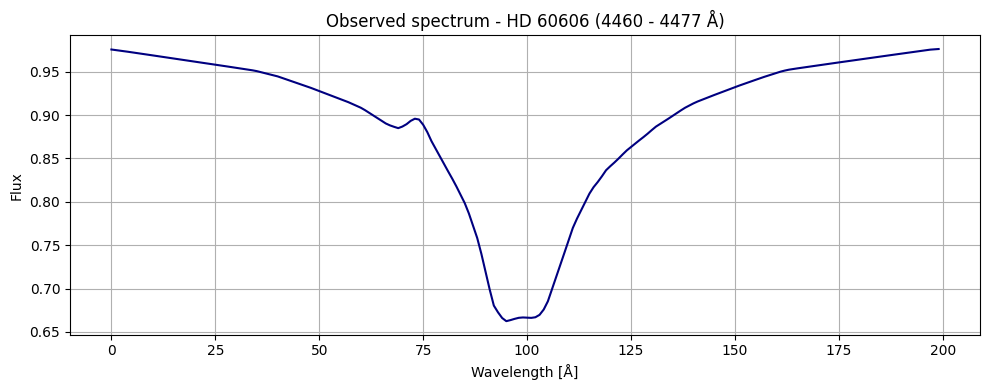

array([ 3.20000000e+04,  3.60000000e+00,  5.00389117e+00,  4.50000000e-01,
        2.50000000e-01,  3.30000000e-01,  4.16556090e+02, -7.04938602e+00,
        7.36000000e+00])

In [4]:
i = 1503
# Graficar el espectro
plt.figure(figsize=(10, 4))
plt.plot(range(200), data[i,:], color="navy", lw=1.5)
plt.xlabel("Wavelength [Å]")
plt.ylabel("Flux")
plt.title("Observed spectrum - HD 60606 (4460 - 4477 Å)")
plt.grid(True)
plt.tight_layout()
# Guardar a archivo PNG
plt.savefig("spectrum_hd60606_4460_4477.png", dpi=300)
plt.show()

y[i]


## Project stages
***


## 1. Data acquisition

In [5]:
data.shape

(10000, 200)

In [6]:
y.shape
# TEFF (effective temperature), LOGG (logarithm of the surface gravity), LOGLSTAR (logarithm of the stellar luminosity),
# ALPHA, K, DELTA (alpha, k, and delta are line-strength parameters),
# VINF (terminal velocity), LOGMDOT (logarithm of the mass-loss rate), SI (silicon abundance)


(10000, 9)

* Only TEFF, LOGG, and LOGMDOT should be selected.

## 2. Exploratory Data Analysis (EDA)


In [7]:
y.shape
y_new = y[:, [0, 1, 7]]

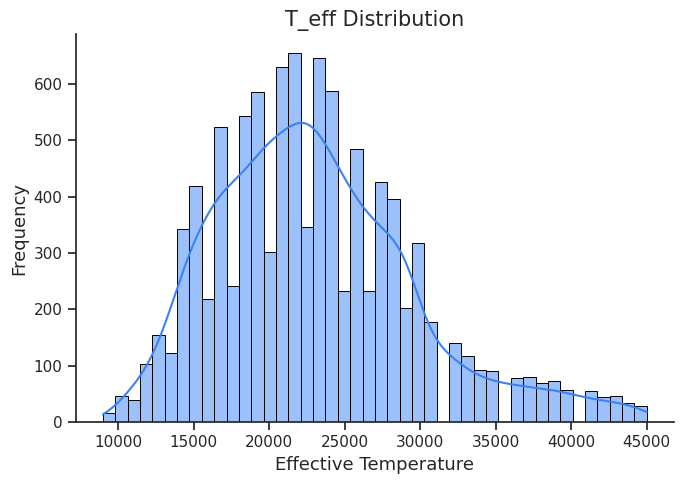

In [8]:
plot_histogram_science_style(
    y_new[:, 0],
    title="T_eff Distribution",
    xlabel="Effective Temperature"
)

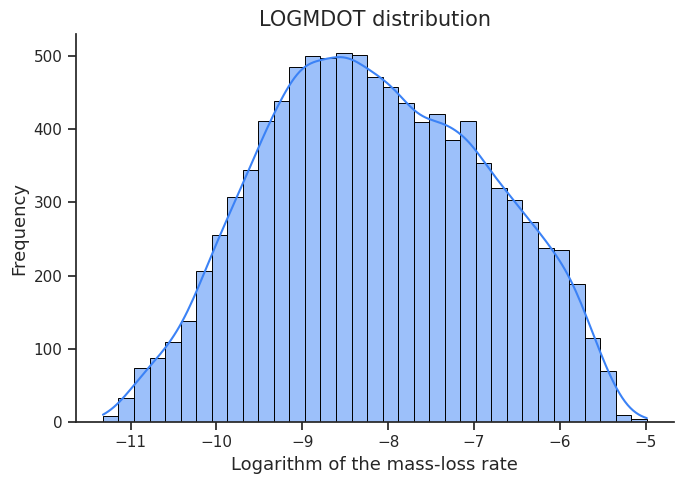

In [9]:
plot_histogram_science_style(
    y_new[:, 2],
    title="LOGMDOT distribution",
    xlabel="Logarithm of the mass-loss rate"
)

In [10]:
y[:,[1]]
valores_unicos, frecuencias = np.unique(y[:,[1]], return_counts=True)


In [11]:
valores_unicos, frecuencias

(array([1.65, 1.8 , 1.95, 2.1 , 2.25, 2.4 , 2.55, 2.7 , 2.85, 3.  , 3.15,
        3.3 , 3.45, 3.6 , 3.75, 3.9 , 4.05, 4.2 ]),
 array([   2,    9,   49,  124,  196,  386,  625,  827,  666,  749,  946,
        1132, 1104,  945,  778,  596,  419,  447]))

## 3. Generation of training, validation, and testing data


### Scaling the data

* The output values are scaled.


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
scaler.fit(y_new)
y_scaled = scaler.transform(y_new)


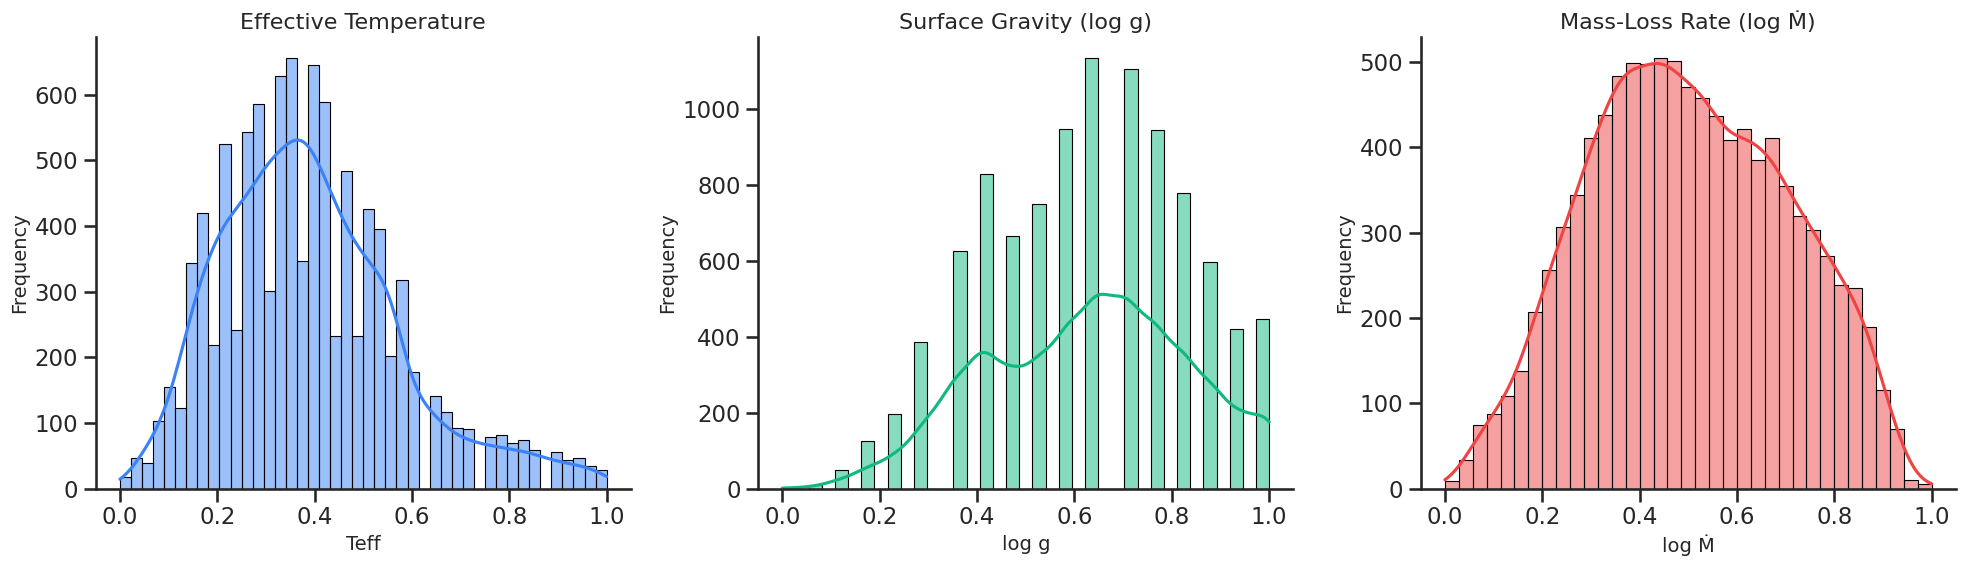

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

# Estilo científico
sns.set_theme(style="ticks", context="talk")

# Crear figura con 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Paleta de colores más elegante
colors = ["#3b82f6", "#10b981", "#ef4444"]  # azul, verde, rojo

# Títulos y labels
titles = ["Effective Temperature", "Surface Gravity (log g)", "Mass-Loss Rate (log Ṁ)"]
xlabels = ["Teff", "log g", "log Ṁ"]

# Generar los 3 histogramas
for i in range(3):
    sns.histplot(
        y_scaled[:, i],
        kde=True,
        color=colors[i],
        edgecolor="black",
        linewidth=0.8,
        ax=axes[i]
    )
    axes[i].set_title(titles[i], fontsize=16)
    axes[i].set_xlabel(xlabels[i], fontsize=14)
    axes[i].set_ylabel("Frequency", fontsize=14)
    sns.despine(ax=axes[i])

# Ajuste final
plt.tight_layout()
plt.show()


In [14]:
X_train, X_test, y_train, y_test = train_test_split(data, y_scaled, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

## 4. Design and implementation of an ML method for parameter prediction

In [15]:
time_steps = X_train.shape[1]
input_dimension = 1

sample_size = X_train.shape[0]
X_train_reshaped = X_train.reshape((sample_size, time_steps, input_dimension))
sample_size = X_val.shape[0]
X_val_reshaped = X_val.reshape((sample_size, time_steps, input_dimension))
sample_size = X_test.shape[0]
X_test_reshaped = X_test.reshape((sample_size, time_steps, input_dimension))

In [16]:
print(X_train_reshaped.shape)
print(X_val_reshaped.shape)
print(X_test_reshaped.shape)

(6400, 200, 1)
(1600, 200, 1)
(2000, 200, 1)


In [17]:
# !pip install tensorflow

In [18]:
import tensorflow as tf
import keras

def build_conv1D_model():
    n_timesteps = X_train_reshaped.shape[1] #210
    n_features  = X_train_reshaped.shape[2] #1
    model = keras.Sequential(name="model_conv1D")
    model.add(keras.layers.Input(shape=(n_timesteps,n_features)))
    model.add(keras.layers.Conv1D(filters=32, kernel_size=7, activation='relu', name="Conv1D_1"))

    model.add(keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', name="Conv1D_2"))
    tf.keras.layers.BatchNormalization()
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(32, activation= "selu", name="Dense_1"))
    model.add(keras.layers.Dense(3, activation = "linear", name="Dense_4"))


    optimizer = tf.keras.optimizers.RMSprop(0.001)

    l = tf.keras.losses.LogCosh()


    model.compile(loss='mse',optimizer=optimizer,metrics=['mse'])
    return model

model_conv1D = build_conv1D_model()
model_conv1D.summary()

Model: "model_conv1D"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Conv1D_1 (Conv1D)               │ (None, 194, 32)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1D_2 (Conv1D)               │ (None, 192, 16)        │         1,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3072)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_1 (Dense)                 │ (None, 32)             │        98,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Dense_4 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 100,243 (391.57 KB)

 Trainable params: 100,243 (391.57 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
ep = 50
callback = tf.keras.callbacks.EarlyStopping(monitor='loss',
                                                patience=5)
history = model_conv1D.fit(X_train_reshaped, y_train, epochs=ep,
                    validation_data = (X_val_reshaped, y_val),
                           verbose=1, callbacks=[callback])

## 5. Training loss and evaluation in testing set

In [20]:
[loss, mae] = model_conv1D.evaluate(X_test_reshaped, y_test, verbose=0)
print("Testing set Mean Abs Error: {:7.2f}".format(mae * 1000))

pred =model_conv1D.predict(X_test_reshaped)

y_pred_inv = scaler.inverse_transform(y_test)


train_loss = history.history['loss']


val_loss = history.history['val_loss']




Testing set Mean Abs Error:    3.85
63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


In [21]:

len(train_loss), len(val_loss)

(50, 50)

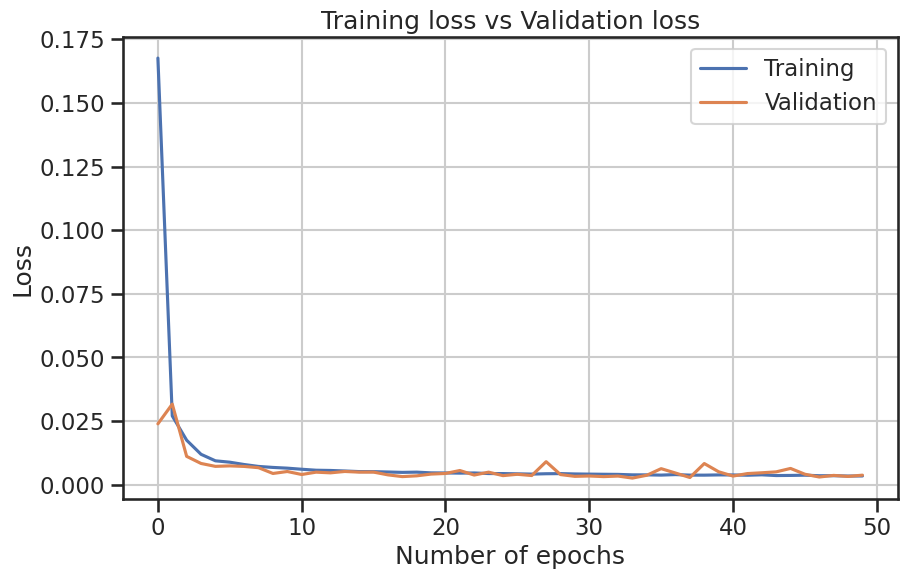

In [22]:
def plot_train_val(A, B, n, xlabel, ylabel, title):
    plt.figure(1, figsize=(10, 6))
    plt.plot(range(n),A)
    plt.plot(range(n),B)
    plt.ylabel(xlabel)
    plt.xlabel(ylabel)
    plt.title(title)
    plt.grid(True)
    plt.legend(['Training', 'Validation'])
    plt.show()


plot_train_val(train_loss, val_loss, len(train_loss), 'Loss', 'Number of epochs', 'Training loss vs Validation loss')

In [23]:
y_test.shape

(2000, 3)

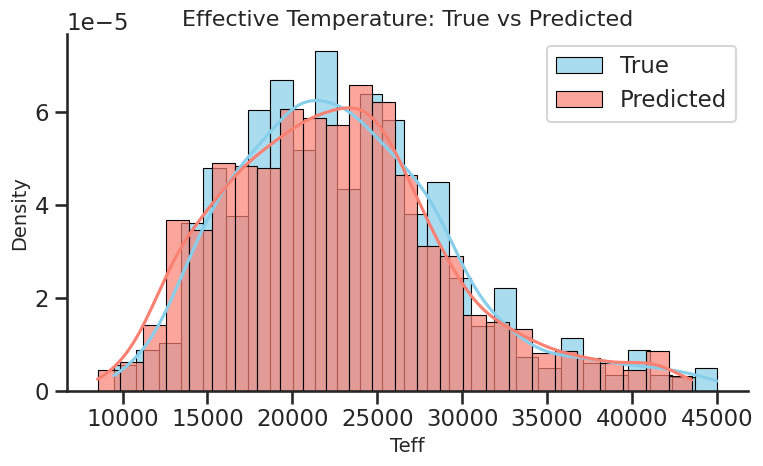

In [24]:
a = scaler.inverse_transform(pred)
b = scaler.inverse_transform(y_test)

plot_true_pred_hist(
    true_values=b[:, 0],
    pred_values=a[:, 0],
    title="Effective Temperature: True vs Predicted",
    xlabel="Teff",
    ylabel="Density",
    true_label="True",
    pred_label="Predicted",
    colors=("skyblue", "salmon")
)


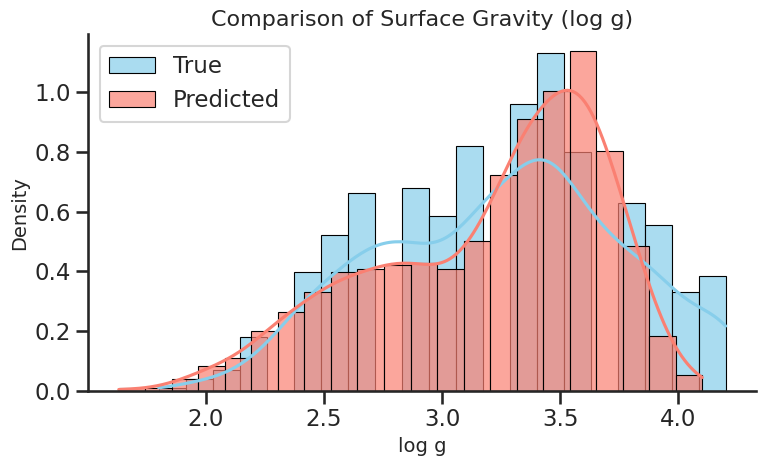

In [25]:
a = scaler.inverse_transform(pred)
b = scaler.inverse_transform(y_test)

plot_true_pred_hist(
    true_values=b[:, 1],          # valores verdaderos
    pred_values=a[:, 1],          # valores predichos
    title="Comparison of Surface Gravity (log g)",
    xlabel="log g",
    ylabel="Density",
    true_label="True",
    pred_label="Predicted",
    colors=("skyblue", "salmon")
)


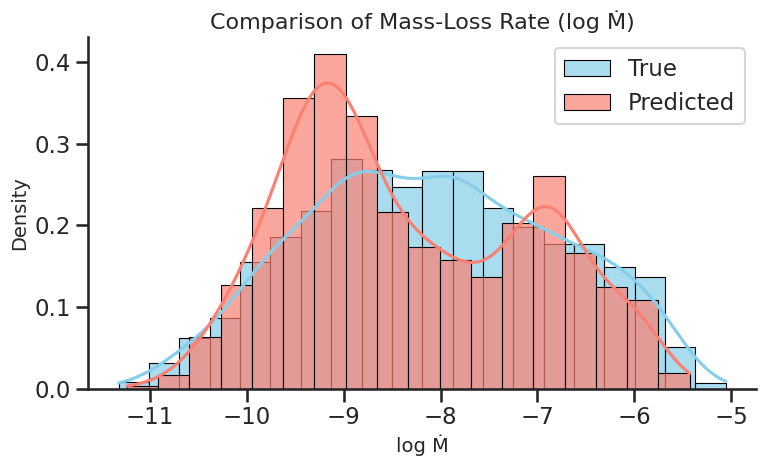

In [26]:
a = scaler.inverse_transform(pred)
b = scaler.inverse_transform(y_test)

plot_true_pred_hist(
    true_values=b[:, 2],
    pred_values=a[:, 2],
    title="Comparison of Mass-Loss Rate (log Ṁ)",
    xlabel="log Ṁ",
    ylabel="Density",
    true_label="True",
    pred_label="Predicted",
    colors=("skyblue", "salmon")
)


## 6. Validation on oberved data

* The observed data contain 8 spectral lines, each with 200 flux points.
* The lines, in order, are: Si IV 4089, Hγ, He I 4387, He I 4471, Si III 4552, Hβ, Hα, and He I 6678.
* Only the Hα line should be extracted for evaluation, since our training data contain only Hα.


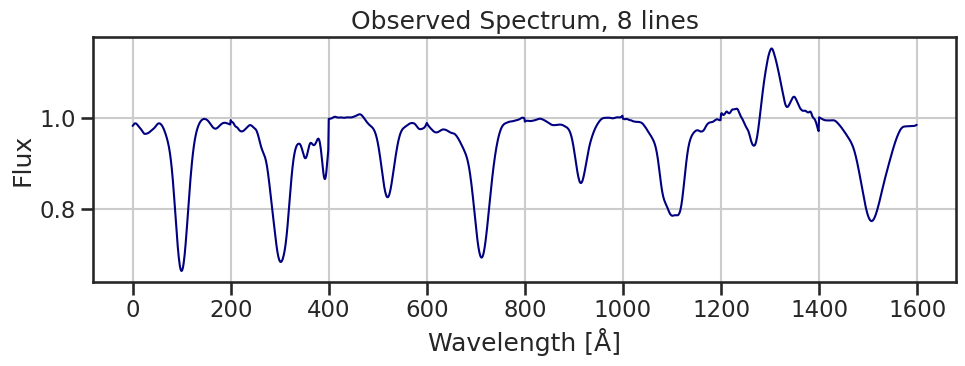

In [27]:
plt.figure(figsize=(10, 4))
plt.plot(range(1600), data_observed[0,:,:].ravel(), color="navy", lw=1.5)
plt.xlabel("Wavelength [Å]")
plt.ylabel("Flux")
plt.title("Observed Spectrum, 8 lines")
plt.grid(True)
plt.tight_layout()
# Guardar a archivo PNG
#plt.savefig("spectrum_hd60606_4460_4477.png", dpi=300)
plt.show()

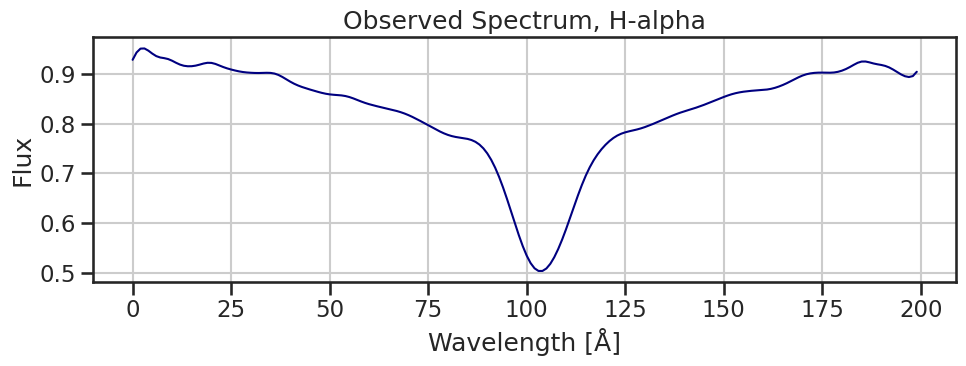

In [28]:
plt.figure(figsize=(10, 4))
plt.plot(range(200), data_observed[12,6,:], color="navy", lw=1.5)
plt.xlabel("Wavelength [Å]")
plt.ylabel("Flux")
plt.title("Observed Spectrum, H-alpha")
plt.grid(True)
plt.tight_layout()
# Guardar a archivo PNG
#plt.savefig("spectrum_hd60606_4460_4477.png", dpi=300)
plt.show()

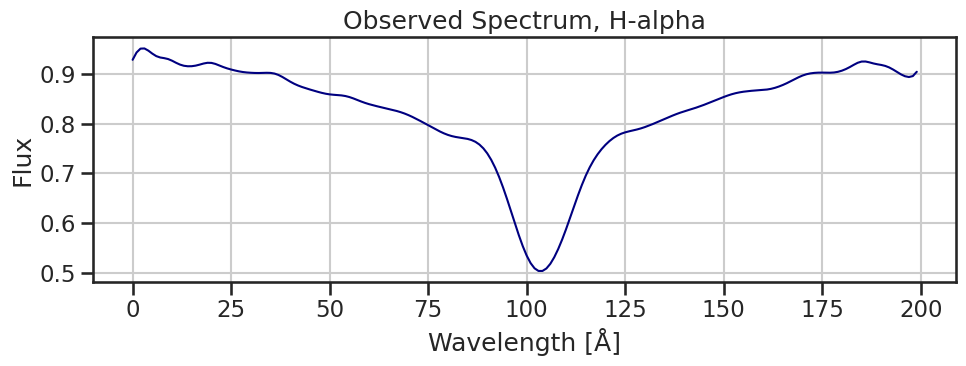

In [29]:
plt.figure(figsize=(10, 4))
plt.plot(range(200), data_observed_p[12,:], color="navy", lw=1.5)
plt.xlabel("Wavelength [Å]")
plt.ylabel("Flux")
plt.title("Observed Spectrum, H-alpha")
plt.grid(True)
plt.tight_layout()
# Guardar a archivo PNG
#plt.savefig("spectrum_hd60606_4460_4477.png", dpi=300)
plt.show()

In [30]:
obs_x_reshaped = data_observed_p[12,:].reshape((1, time_steps, input_dimension))
pred_obs =model_conv1D.predict(obs_x_reshaped)
#print(pred_obs)
print( "--- ", i, "---")
pred_obs_inv = scaler.inverse_transform(pred_obs)
print(pred_obs_inv)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 318ms/step
---  2 ---
[[ 3.446654e+04  3.921898e+00 -9.861294e+00]]


In [ ]:
import pandas as pd

predicciones_lista = []
for i in range(data_observed_p.shape[0]):
    obs_x_reshaped = data_observed_p[i,:].reshape((1, time_steps, input_dimension))
    pred_obs =model_conv1D.predict(obs_x_reshaped)
#    print("--",i,"---")
    pred_obs_inv = scaler.inverse_transform(pred_obs)
#    print(pred_obs_inv)

    predicciones_lista.append(pred_obs_inv.flatten())



In [32]:
# Create the DataFrame with the predictions
df_predictions = pd.DataFrame(predicciones_lista)
df_predictions.index.name = "spectrum_ID"

# Optional: add column names if you know them
df_predictions.columns = ["Teff", "Logg", "MassLoss"]



In [33]:
df_predictions

,Teff,Logg,MassLoss
spectrum_ID,,,
0,34040.890625,4.156328,-7.023733
1,35764.468750,3.833151,-6.482493
2,35534.160156,3.968273,-6.685812
3,32726.431641,3.527765,-7.192043
4,34074.148438,3.620195,-8.483968
...,...,...,...
71,25012.775391,3.934127,-7.810340
72,27023.453125,3.862911,-10.548367
73,37426.269531,3.348923,-6.661162


In [34]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Model, Input

def build_multitask_conv1D_model(n_classes_logg=18):
    n_timesteps = X_train_reshaped.shape[1]
    n_features  = X_train_reshaped.shape[2]

    inputs = Input(shape=(n_timesteps, n_features), name="input_layer")

    x = layers.Conv1D(filters=32, kernel_size=7, activation='relu', name="Conv1D_1")(inputs)
    x = layers.Conv1D(filters=16, kernel_size=3, activation='relu', name="Conv1D_2")(x)
    x = layers.Flatten()(x)
    x = layers.Dense(32, activation="selu", name="Dense_shared")(x)

    # Rama regresión: Teff y log Ṁ
    reg_output = layers.Dense(2, activation="linear", name="regression_output")(x)

    # Rama clasificación: log g con softmax
    clf_output = layers.Dense(n_classes_logg, activation="softmax", name="classification_output")(x)

    model = Model(inputs=inputs, outputs=[reg_output, clf_output], name="model_conv1D_multitask")

    model.compile(
        loss={
            "regression_output": "mse",
            "classification_output": "sparse_categorical_crossentropy"
        },
        optimizer=tf.keras.optimizers.RMSprop(0.001),
        metrics={
            "regression_output": "mae",
            "classification_output": "accuracy"
        }
    )

    return model

model_conv1D = build_multitask_conv1D_model()
model_conv1D.summary()


Model: "model_conv1D_multitask"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 200, 1)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1D_1 (Conv1D)   │ (None, 194, 32)   │        256 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1D_2 (Conv1D)   │ (None, 192, 16)   │      1,552 │ Conv1D_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 3072)      │          0 │ Conv1D_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Dense_shared        │ (None, 32)        │     98,336 │ flatten_1[0][0]   │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ regression_output   │ (None, 2)         │         66 │ Dense_shared[0][… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ classification_out… │ (None, 18)        │        594 │ Dense_shared[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 100,804 (393.77 KB)

 Trainable params: 100,804 (393.77 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
y_train_reg = y_train[:,[0,2]]
y_train_clf = y_train[:,1]

y_val_reg = y_val[:,[0,2]]
y_val_clf = y_val[:,1]

history = model_conv1D.fit(
    X_train_reshaped,
    {"regression_output": y_train_reg, "classification_output": y_train_clf},
    validation_data=(X_val_reshaped, {"regression_output": y_val_reg, "classification_output": y_val_clf}),
    epochs=50,
    batch_size=32
)

In [36]:
y_pred_reg, y_pred_clf = model_conv1D.predict(X_test_reshaped)

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


In [37]:
pred_class = np.argmax(y_pred_clf, axis=1)  # Clase más probable

In [38]:
pred_class

array([0, 0, 0, ..., 0, 0, 0])

In [39]:
logg_values = list(valores_unicos)
logg_pred_real = [logg_values[i] for i in pred_class]

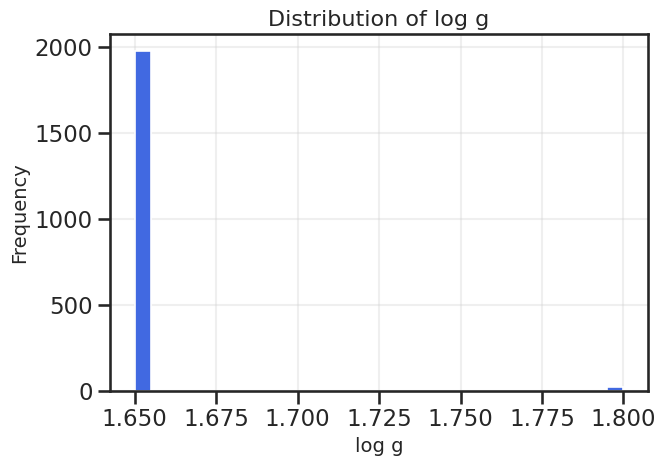

In [40]:
plt.figure(figsize=(7,5))
plt.hist(logg_pred_real, bins=30, color="royalblue", edgecolor="white", linewidth=1.2)

plt.title("Distribution of log g", fontsize=16)
plt.xlabel("log g", fontsize=14)
plt.ylabel("Frequency", fontsize=14)

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()
